# Single Particle Model (SPM): External short circuit

## Model Equations

The SPM consists of two spherically symmetric diffusion equations: one within a representative negative particle ($\text{k}=\text{n}$) and one within a representative positive particle ($\text{k}=\text{p}$). In the centre of the particle the standard no-flux condition is imposed. Since the SPM assumes that all particles in an electrode behave in exactly the same way, the flux on the surface of a particle is simply the current $I$ divided by the thickness of the electrode $L_{\text{k}}$. The concentration of lithium in electrode $\text{k}$ is denoted $c_{\text{k}}$ and the current is denoted by $I$. All parameters in the model stated here are dimensionless and are given in terms of dimensional parameters at the end of this notebook. The model equations for the SPM are then: 
\begin{align}
\mathcal{C}_{\text{k}} \frac{\partial c_{\text{s,k}}}{\partial t} &= -\frac{1}{r_{\text{k}}^2} \frac{\partial}{\partial r_{\text{k}}} \left(r_{\text{k}}^2 N_{\text{s,k}}\right), \\
N_{\text{s,k}} &= -D_{\text{s,k}}(c_{\text{s,k}}) \frac{\partial c_{\text{s,k}}}{\partial r_{\text{k}}}, \quad \text{k} \in \text{n, p}, \end{align}
$$
N_{\text{s,k}}\big|_{r_{\text{k}}=0} = 0, \quad \text{k} \in \text{n, p}, \quad \ \ - \frac{a_{R, \text{k}}\gamma_{\text{k}}}{\mathcal{C}_{\text{k}}} N_{\text{s,k}}\big|_{r_{\text{k}}=1} = 
\begin{cases}
		  \frac{I}{L_{\text{n}}}, \quad &\text{k}=\text{n}, \\ 
		  -\frac{I}{L_{\text{p}}}, \quad &\text{k}=\text{p}, 
\end{cases} \\
c_{\text{s,k}}(r_{\text{k}},0) = c_{\text{s,k,0}}, \quad \text{k} \in \text{n, p},$$
where $D_{\text{s,k}}$ is the diffusion coefficient in the solid, $N_{\text{s,k}}$ denotes the flux of lithium ions in the solid particle within the region $\text{k}$, and $r_{\text{k}} \in[0,1]$ is the radial coordinate of the particle in electrode $\text{k}$. 

### Voltage Expression
The terminal voltage is obtained from the expression: 
$$
V = U_{\text{p}}(c_{\text{p}})\big|_{r_{\text{p}}=1} - U_{\text{n}}(c_{\text{n}})\big|_{r_{\text{n}}=1} -2\sinh^{-1}\left(\frac{I}{j_{\text{0,p}} L_{\text{p}}}\right) - 2\sinh^{-1}\left(\frac{I}{j_{\text{0,n}} L_{\text{n}}}\right)
$$
with the exchange current densities given by
$$j_{\text{0,k}} =  \frac{\gamma_{\text{k}}}{\mathcal{C}_{\text{r,k}}}(c_{\text{k}})^{1/2}(1-c_{\text{k}})^{1/2}  $$

More details can be found in [[3]](#References).

## Example solving SPM using PyBaMM

Below we show how to solve the Single Particle Model, using the default geometry, mesh, parameters, discretisation and solver provided with PyBaMM. In this notebook we explicitly handle all the stages of setting up, processing and solving the model in order to explain them in detail. However, it is often simpler in practice to use the `Simulation` class, which handles many of the stages automatically, as shown [here](../simulation-class.ipynb).

First we need to import `pybamm`, and then change our working directory to the root of the pybamm folder. 

In [1]:
# need to restart jupyter server? kernal? whenever a change is made to the pybamm module? 
import sys
import os
import numpy as np
import pandas as pd
import os
from scipy import integrate
import matplotlib.pyplot as plt
os.chdir(sys.path[0] + '\..') # change our working directory to the root of the pybamm folder
import pybamm
print(pybamm.__path__[0])
%matplotlib widget
# inline
import inspect



c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm


In [2]:
class ExternalCircuitResistanceFunction():
    def __call__(self, variables):
        I = variables["Current [A]"]
        V = variables["Terminal voltage [V]"]
        R_ext = pybamm.FunctionParameter("External resistance [Ohm]",  {"Time [s]": pybamm.t}) 
        R_tab = pybamm.FunctionParameter("Tabbing resistance [Ohm]",  {"Time [s]": pybamm.t})
        return V/I - (R_ext + R_tab)

# Set up concentration dependent functions

In [3]:
from pybamm import exp, constants, Parameter


def modified_graphite_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Negative electrode diffusion coefficient [m2.s-1]")
    # D_ref = 16*5.0 * 10 ** (-15)
    E_D_s = 42770/10
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    # soc = (sto - 0.036)/(0.842-0.036)
    soc = (sto - 0)/(0.8321-0)


    # k = -11.79206386*soc**3 + 19.74642427*soc**2 -9.58613417*soc + 2.18105841 #fitted without thermal model
    # k = 0.86610992*soc + 0.15162466 #11?
    k = 0.99*soc + 0.01 #
    # k = 0.87357202*soc + 0.33860552 #9
    # k = 0.86681782*soc + 0.16565809 #13

    # p_high = -15.88891693*soc**3 + 32.73897665*soc**2 -22.08987841*soc + 5.8916456 # high SOC
    # p_low = 15.47540036*soc**2 -10.8508352*soc + 2.13736774 # low SOC
    # k = p_high*(1/(1 + exp(-(soc-0.4)*150)))+ p_low*(1-1/(1 + exp(((0.4-soc)*150))))

    # Ds11
    # p_high = 1.3792875#-15.85192692*soc**3 + 34.1354626*soc**2 -23.71872136*soc + 6.33107728 # high SOC
    # p_low = 0.23807837 #0.35006582 # low SOC
    # # p_high = -0.9128685*soc + 1.95773523
    # # p_low = -1.40355492 + 0.68102741
    # k = p_high*(1/(1 + exp(-(soc-0.4)*20)))+ p_low*(1-1/(1 + exp(((0.4-soc)*20))))

    return D_ref*k # *(-0.9 * sto + 1)

def modified_NMC_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Positive electrode diffusion coefficient [m2.s-1]")
    E_D_s = 18550/10
    soc = (0.837-sto)/(0.837-0.034)
    # k = 3.77967906*soc**2 - 3.54525492*soc + 1.04220164 # 8 fitted with thermal model 
    # k = 2.61225029*soc**2 - 2.17500416*soc + 0.69677927 # 13 fitted with thermal model 
    k = 3.73478491*soc**2 - 3.50522373*soc + 1.03247363 # 8?fitted without thermal model

    # k = 3.12530118*soc**2 -2.7858167*soc + 0.86291605 # 9 removing high error fits. fitted without thermal model
    # k =  3.32316507*soc**2 -3.06075959*soc + 0.94787949 # 11 removing high error fits k0=[SOC_0]*2
    # k = 0.62889645*soc +0.08790276

    # p_high = -7.54090264*soc**3 +17.18863735*soc**2 -10.57421123*soc + 1.97512672 # high SOC
    # p_low = 6.12915318*soc**2 -4.58479402*soc + 1.06832757# low SOC
    # k = p_high*(1/(1 + exp(-(soc-0.6)*150)))+ p_low*(1-1/(1 + exp(((0.6-soc)*150))))
    # arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
    
    return D_ref *k

def modified_electrolyte_diffusivity_PeymanMPM(c_e, T):
    # D_c_e = 5.35 * 10 ** (-10)
    D_c_e =  Parameter("Typical electrolyte diffusivity [m2.s-1]")
    E_D_e = 37040
    arrhenius = exp(E_D_e / constants.R * (1 / 298.15 - 1 / T))
    # k = Parameter("Electrolyte diffusion scalar")
    # k_T =  1/(1 + exp(-10*((114+273.15)-T))*(1-0.5)+0.5)
    # k_T=1
    # D_c_e = 8.794e-11 * (c_e/ 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    # k_T =  pybamm.sigmoid(T,114+273.15,10).evaluate()*(1-0.1) + 0.5
    return D_c_e#*arrhenius

def modified_electrolyte_conductivity_PeymanMPM(c_e, T):
    # sigma_e = 1.3
    sigma_e = Parameter("Typical electrolyte conductivity [m2.s-1]")
    E_k_e = 34700
    arrhenius = exp(E_k_e / constants.R * (1 / 298.15 - 1 / T))

    # k_T = 1*(1/(1 + exp(-(T-(114+273.15))*150)))+ 1*(1-1/(1 + exp(((114+273.15)-T)*150)))
    # k_T =  1#pybamm.sigmoid(T,114+273.15,10).evaluate()*(1-0.1) + 0.5
    # k_T =  1/(1 + exp(-5*((114+273.15)-T))*(1-0.9)+0.9)
    return sigma_e#*k_T# (1-k)#*arrhenius

def modified_NMC_electrolyte_exchange_current_density_PeymanMPM(c_e, c_s_surf, c_s_max, T):
    m_ref =  Parameter("Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4.824 * 10 ** (-6)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 39570
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )

def modified_graphite_electrolyte_exchange_current_density_PeymanMPM(c_e, c_s_surf, c_s_max, T):
    m_ref =  Parameter("Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4*1.061 * 10 ** (-6)  # unit has been converted
    # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 37480
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )

# Simulate 100% SOC ESC

## Nominal model

In [4]:
solutions = []
SOC_0 = 1
SOC_name = SOC_0
Q_nom = 4.6
h = 0.72753047-0.05 #0.77996386
Cp = 1.51997699 #1.94584251
R_tab = pybamm.Parameter("Tabbing resistance [Ohm]")
R_ext = pybamm.Parameter("External resistance [Ohm]")
data_sets = []
# R_tab_list =  [0.0085]#, 0.015] # 0.0085 (100%), 0.0078 (75%), 0.007? (50%)

# load data import ESC data from file
raw_data = pd.read_csv("./fast_discharge/ESC_"+  str(int(SOC_name*100)) + "SOC_full.csv")
esc_start = raw_data[-raw_data['Current Shunt']>1].index[0]
esc_end = len(raw_data)
# T_amb = np.mean(raw_data['Cell Temperature'][(raw_data.index < esc_start) & (raw_data['Cell Temperature'] >0)])
data = raw_data[['Time (s)', 'Voltage (V)', 'Cell Temperature', 'Current Shunt', 'Force']].loc[esc_start:esc_end].copy()
data['Current Shunt'] = -data['Current Shunt']
data['Time (s)'] = data['Time (s)'] - data['Time (s)'].loc[esc_start]
df_labels = ['t', 'V', 'Temp','I', 'F']
data.set_axis(df_labels, axis=1, inplace=True)
data['I_C'] = data.I/Q_nom 
AhT_calculated = integrate.cumtrapz(abs(data.I), data.t-data.t.iloc[0])/3600
AhT_calculated = np.append(AhT_calculated,AhT_calculated[-1])
data['SOC'] = SOC_0 - AhT_calculated/Q_nom 
T_amb = data.Temp.iloc[0]
data_sets.append(data)

options = {
    # "thermal": "x-lumped",
#         "side reactions": "decomposition", 
    "operating mode": ExternalCircuitResistanceFunction(),
}
model = pybamm.lithium_ion.SPMe(options = options)
chemistry = pybamm.parameter_sets.Mohtat2020
# chemistry["electrolyte"] = "lipf6_Nyman2008"
# chemistry["electrolyte"] = "LiPF6_Mohtat2020"
param = pybamm.ParameterValues(chemistry)

param.update({
    "Tabbing resistance [Ohm]":  0.0085,#0.0041,D
    "External resistance [Ohm]": 0.0067, # 0.0067
    "Cell capacity [A.h]": Q_nom, #nominal
    "Typical current [A]": Q_nom,
    'Nominal cell capacity [A.h]': Q_nom,
    "Negative electrode thickness [m]":62E-06*4.2/5,
    "Positive electrode thickness [m]":67E-06*4.2/5,
    "Lower voltage cut-off [V]": 0,
    "Ambient temperature [K]":T_amb + 273.15,
    "Initial temperature [K]": T_amb + 273.15,
    "Negative tab width [m]":2.5e-2,
    "Positive tab width [m]":2.5e-2,
    "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
    "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
    "Negative tab heat transfer coefficient [W.m-2.K-1]":h,  
    "Positive tab heat transfer coefficient [W.m-2.K-1]":h,  
    "Edge heat transfer coefficient [W.m-2.K-1]":h,
    "Total heat transfer coefficient [W.m-2.K-1]":h,
    "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
    "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
    "Negative electrode diffusivity [m2.s-1]": 8e-14,
    "Positive electrode diffusivity [m2.s-1]": 8e-15,
    "Electrolyte diffusivity [m2.s-1]": modified_electrolyte_diffusivity_PeymanMPM, #set constant. ignore temperature dependence
    "Electrolyte conductivity [S.m-1]": modified_electrolyte_conductivity_PeymanMPM, #set constant. ignore temperature dependence
    "Negative electrode exchange-current density [A.m-2]": modified_graphite_electrolyte_exchange_current_density_PeymanMPM,
    "Positive electrode exchange-current density [A.m-2]": modified_NMC_electrolyte_exchange_current_density_PeymanMPM,
    # "Diffusion stoichiometry scalar": 2,
    # "Diffusion stoichiometry offset": 1,
    # "Electrolyte diffusion scalar":100,
}, check_already_exists = False)

V = model.variables["Terminal voltage [V]"]
I = model.variables["Current [A]"]
model.variables.update({
    "Terminal voltage [V]": V - I*R_tab,
    "Actual resistance [Ohm]":V/I,
    }
)

dt = 0.1
t_eval = np.arange(0, 8*60, dt)
solver = pybamm.CasadiSolver(mode="safe") #, extra_options_setup={"max_num_steps": 10000}
sim = pybamm.Simulation(model, parameter_values = param, solver=solver) 
solution = sim.solve( initial_soc=SOC_0, t_eval = t_eval)
solutions.append(solution)

C:\Users\Vivian\AppData\Local\Temp\ipykernel_2972\3399963100.py:21: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data.set_axis(df_labels, axis=1, inplace=True)
At t = 0.0082916 and h = 2.36823e-010, the corrector convergence failed repeatedly or with |h| = hmin.


## Add Dp(c)

In [5]:
param.update({
        "Positive electrode diffusivity [m2.s-1]": modified_NMC_diffusivity_PeymanMPM,
})
solver = pybamm.CasadiSolver(mode="safe", dt_max=0.1) #, extra_options_setup={"max_num_steps": 10000}
sim = pybamm.Simulation(model, parameter_values = param, solver=solver) 
solution = sim.solve( initial_soc=SOC_0, t_eval = t_eval)
solutions.append(solution)

## Add Dn(c) 

In [6]:
param.update({
        "Negative electrode diffusivity [m2.s-1]": modified_graphite_diffusivity_PeymanMPM,
})
solver = pybamm.CasadiSolver(mode="safe", dt_max=1) #, extra_options_setup={"max_num_steps": 10000}
sim = pybamm.Simulation(model, parameter_values = param, solver=solver) 
solution = sim.solve( initial_soc=SOC_0, t_eval = t_eval)
solutions.append(solution)

## FIG: Effect of concentration-dependence

2023-05-09 16:07:15.530 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:07:17.249 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:07:18.800 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


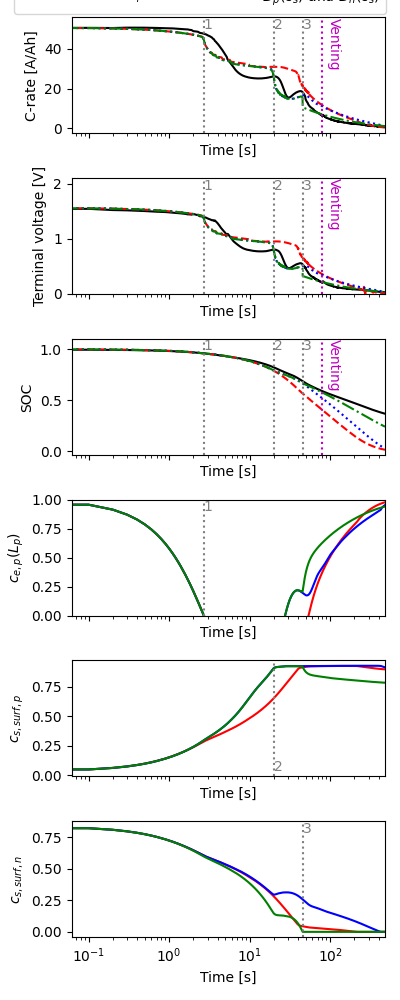

In [7]:
%matplotlib widget
labels = ["Constant $D_p$ and $D_n$", "$D_p(c_s)$", "$D_p(c_s)$ and $D_n(c_s)$"]

fig, ax = plt.subplots(6,1, figsize=(4,10), sharex=True)
ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['r','b','g']

t_transition = []
for l, solution in enumerate(solutions):
    # data = data_sets[l]
    t = solution["Time [s]"].entries
    x = solution["x [m]"].entries[:, 0]
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t
    xlabel = "Time [s]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = 'k' 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    I = solution['C-rate']
    if l ==0:
        ax[0].semilogx(data.t,data.I/param['Nominal cell capacity [A.h]'], label='Data',color = data_color)
    ax[0].semilogx(x_plot, I(t), linestyle=sim_ls, color = sim_color, label=labels[l])
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('C-rate [A/Ah]')
    # ax[0].legend(loc = "lower left",  prop={'size': 10})

    V = solution['Terminal voltage [V]']
    if l ==0:
        ax[1].semilogx(data.t, data.V,color = data_color)
    ax[1].semilogx(x_plot, V(t),linestyle=sim_ls, color = sim_color)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Terminal voltage [V]')
    ax[1].set_ylim([0,2])
    # ax[0,1].legend(bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=len(SOC_0), prop={'size': 10}) #, 

    c_n_avg = solution['R-averaged negative particle concentration'](t=t, x=x[0])
    soc = (c_n_avg - 0)/(0.8321-0)
    e_soc = (solution['R-averaged negative particle concentration'](t=data.t, x=x[0])- 0)/(0.8321-0) -  data.SOC
    x = solution["x [m]"].entries[:, 0]
    if l ==0:
        ax[2].semilogx(data.t, data.SOC,color = data_color, label = 'Data')
    ax[2].semilogx(x_plot, soc,linestyle=sim_ls, color = sim_color, label = labels[l])  # can evaluate at arbitrary x (single representative particle)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel('SOC')

    c_e_p= solution['Positive electrolyte concentration']
    # x = solution["x [m]"].entries[:, 0]
    ax[3].semilogx(x_plot, c_e_p (t=t, x = x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[3].set_xlabel(xlabel)
    ax[3].set_ylabel('$c_{e,p}(L_p)$') # [mol.m-3]
    ax[3].set_ylim([0,1])

    # c_e_n = solution['X-averaged negative electrolyte concentration']
    # # x = solution["x [m]"].entries[:, 0]
    # ax[4].semilogx(x_plot, c_e_n (t=t),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[4].set_xlabel(xlabel)
    # ax[4].set_ylabel('$c_{e,n}$')

    c_s_p_surf = solution['Positive particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[4].semilogx(x_plot, c_s_p_surf(t=t, x=x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[4].set_xlabel(xlabel)
    ax[4].set_ylabel('$c_{s,surf,p}$')


    # # Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])
    # Dp = solution['Positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-21],r=[0])
    # # ax[7].semilogx(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$")  # can evaluate at arbitrary x (single representative particle)
    # ax[5].semilogx(x_plot, Dp, color = sim_color, label = "$D_p$")  # can evaluate at arbitrary x (single representative particle)
    # ax[5].set_ylabel('$D_p$')
    # # ax[5].legend(loc = 'upper left', ncol=3)
    # ax[5].set_ylim([0, 1.5e-14])

    c_s_n_surf = solution['Negative particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[5].semilogx(x_plot, c_s_n_surf(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[5].set_xlabel(xlabel)
    ax[5].set_ylabel('$c_{s,surf,n}$')


    # i0 = solution[ 'Negative electrode exchange current density [A.m-2]']
    # x = solution["x [m]"].entries[:, 0]
    # ax[7].plot(x_plot, i0(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[7].set_xlabel(xlabel)
    # ax[7].set_ylabel('$i_{0,n}$ [A.m-2]')

    # i0 = solution[ 'Positive electrode exchange current density [A.m-2]']
    # x = solution["x [m]"].entries[:, 0]
    # ax[8].plot(x_plot, i0(t=t, x=x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[8].set_xlabel(xlabel)
    # ax[8].set_ylabel('$i_{0,p}$ [A.m-2]')

    # eta = solution['Negative electrode reaction overpotential [V]']
    # phi = solution['Negative electrolyte potential [V]']
    # x = solution["x [m]"].entries[:, 0]
    # ax[1,3].plot(x_plot, eta(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,3].plot(x_plot, phi(t=t, x=x[0]),color = sim_color, linestyle = ':' )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,3].set_xlabel(xlabel)
    # ax[1,3].set_ylabel('$\eta_n$ [V]')

    # plot transition lines 
    c = 'grey'
    if l  == len(solutions)-1:
        t_transition.append(t[np.where(c_e_p (t=t, x = x[-1]) <=0)[0][0]]) # cep first =0
        t_transition.append(t[np.where(abs(np.diff(c_s_p_surf(t=t, x = x[-1])))<1e-3)[0][0]]) # cep first =0
        # t_transition.append(t[np.where(c_s_n_surf(t=t, x = x[0]) < min(c_s_n_surf(t=t, x = x[0])*1.1))[0][0]])
        # t_transition.append(t[np.where(i0(t=t, x = x[0]) == min(i0(t=t, x = x[0])))[0][0]])
        t_transition.append(t[np.where(np.diff(c_s_n_surf(t=t, x = x[0]))>-1e-6)][0])
    
        #for each subplot
        for i, axs in enumerate(fig.get_axes()):
            ylims = axs.get_ylim()
            # make a verical line with annotation at each transition time
            if i>2: 
                t_trans = t_transition[i-3]
                axs.plot([t_trans]*2, list(ylims), color = c, linestyle = ':')
                if i in [3,5]: # top annotation
                    axs.annotate(str(i-2), xy=(t_trans, np.diff(ylims)*0.90+ ylims[0]), color = c) #
                else: # bottom annotation
                    axs.annotate(str(i-2), xy=(t_trans, np.diff(ylims)*0.05+ ylims[0]), color = c) #
                axs.set_ylim(ylims) # keep original limits

            else:
                ylims = [ylims[0], ylims[1]*1.05] #make more room at the top
                for r, t_trans in enumerate(t_transition):
                    axs.plot([t_trans]*2, list(ylims), color = c, linestyle = ':')
                    axs.annotate(str(r+1), xy=(t_trans, np.diff(ylims)*0.90+ ylims[0]), color = c)
                axs.plot([80]*2, list(ylims), color = 'm', linestyle = ':')
                axs.annotate('Venting', xy=(90, np.diff(ylims)*0.57+ ylims[0]), color = 'm', rotation=-90) #
                axs.set_ylim(ylims) # keep original limits
            # venting line
            # if i ==0:
            # axs.plot([80]*2, list(ylims), color = 'm', linestyle = ':')
            # axs.annotate('Venting', xy=(90, np.diff(ylims)*0.57+ ylims[0]), color = 'm', rotation=-90) #
        # axs.grid()



# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', prop={'size': 10}, ncol = 2, bbox_to_anchor=(0.5, 1.05), fancybox=True) #ncol=len(labels)
plt.xlim([t_eval[0],t_eval[-1]])
plt.tight_layout()
plt.savefig('./fast_discharge/figs/effect_D_c_long.eps', format='eps')
plt.show()


2023-05-09 16:07:21.860 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:07:22.604 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:07:23.345 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


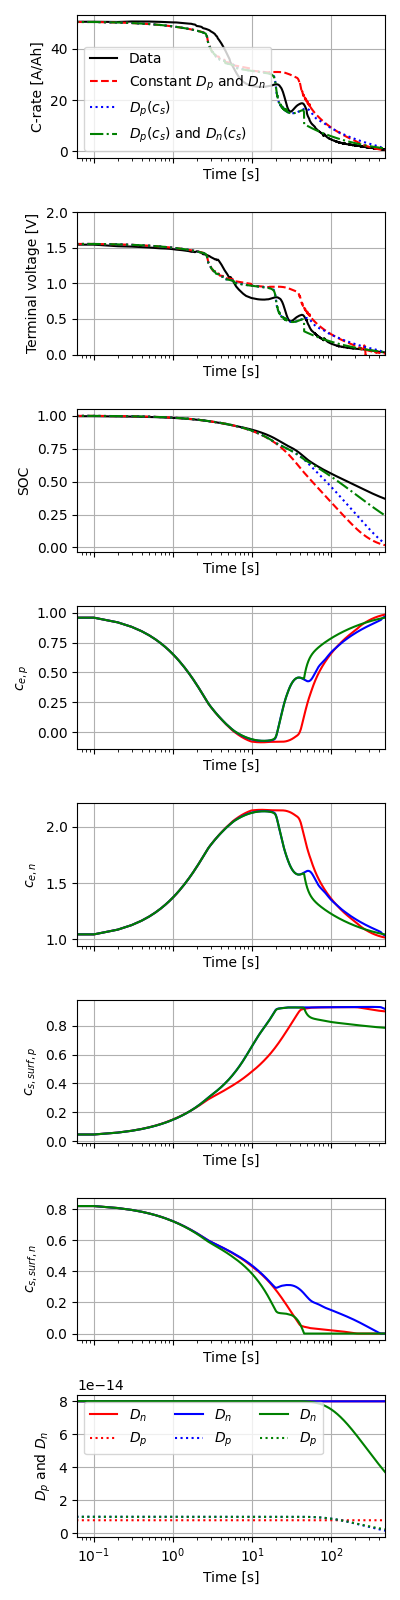

No such comm: ccd0a0790c96414792d7428da8f2888a


In [8]:
%matplotlib widget
labels = ["Constant $D_p$ and $D_n$", "$D_p(c_s)$", "$D_p(c_s)$ and $D_n(c_s)$"]

fig, ax = plt.subplots(8,1, figsize=(4,16), sharex=True)
ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['r','b','g']

for l, solution in enumerate(solutions):
    # data = data_sets[l]
    t = solution["Time [s]"].entries
    x = solution["x [m]"].entries[:, 0]
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t
    xlabel = "Time [s]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = 'k' 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    I = solution['C-rate']
    if l ==0:
        ax[0].semilogx(data.t,data.I/param['Nominal cell capacity [A.h]'], label='Data',color = data_color)
    ax[0].semilogx(x_plot, I(t), linestyle=sim_ls, color = sim_color, label=labels[l])
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('C-rate [A/Ah]')
    ax[0].legend(loc = "lower left",  prop={'size': 10})

    V = solution['Terminal voltage [V]']
    if l ==0:
        ax[1].semilogx(data.t, data.V,color = data_color)
    ax[1].semilogx(x_plot, V(t),linestyle=sim_ls, color = sim_color)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Terminal voltage [V]')
    ax[1].set_ylim([0,2])
    # ax[0,1].legend(bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=len(SOC_0), prop={'size': 10}) #, 

    c_n_avg = solution['R-averaged negative particle concentration'](t=t, x=x[0])
    soc = (c_n_avg - 0)/(0.8321-0)
    e_soc = (solution['R-averaged negative particle concentration'](t=data.t, x=x[0])- 0)/(0.8321-0) -  data.SOC
    x = solution["x [m]"].entries[:, 0]
    if l ==0:
        ax[2].semilogx(data.t, data.SOC,color = data_color, label = 'Data')
    ax[2].semilogx(x_plot, soc,linestyle=sim_ls, color = sim_color, label = labels[l])  # can evaluate at arbitrary x (single representative particle)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel('SOC')

    c_e_p= solution['X-averaged positive electrolyte concentration']
    # x = solution["x [m]"].entries[:, 0]
    ax[3].semilogx(x_plot, c_e_p (t=t),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[3].set_xlabel(xlabel)
    ax[3].set_ylabel('$c_{e,p}$') # [mol.m-3]

    c_e_n = solution['X-averaged negative electrolyte concentration']
    # x = solution["x [m]"].entries[:, 0]
    ax[4].semilogx(x_plot, c_e_n (t=t),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[4].set_xlabel(xlabel)
    ax[4].set_ylabel('$c_{e,n}$')

    c_s_p_surf = solution['Positive particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[5].semilogx(x_plot, c_s_p_surf(t=t, x=x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[5].set_xlabel(xlabel)
    ax[5].set_ylabel('$c_{s,surf,p}$')

    c_s_n_surf = solution['Negative particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[6].semilogx(x_plot, c_s_n_surf(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[6].set_xlabel(xlabel)
    ax[6].set_ylabel('$c_{s,surf,n}$')


    # i0 = solution[ 'Negative electrode exchange current density [A.m-2]']
    # x = solution["x [m]"].entries[:, 0]
    # ax[1,2].plot(x_plot, i0(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].set_xlabel(xlabel)
    # ax[1,2].set_ylabel('$i_{0,n}$ [A.m-2]')

    # eta = solution['Negative electrode reaction overpotential [V]']
    # phi = solution['Negative electrolyte potential [V]']
    # x = solution["x [m]"].entries[:, 0]
    # ax[1,3].plot(x_plot, eta(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,3].plot(x_plot, phi(t=t, x=x[0]),color = sim_color, linestyle = ':' )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,3].set_xlabel(xlabel)
    # ax[1,3].set_ylabel('$\eta_n$ [V]')





    Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])
    Dp = solution['X-averaged positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-1],r=[0])
    ax[7].semilogx(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$")  # can evaluate at arbitrary x (single representative particle)
    ax[7].semilogx(x_plot, Dp, linestyle=':', color = sim_color, label = "$D_p$")  # can evaluate at arbitrary x (single representative particle)
    ax[7].set_xlabel(xlabel)
    ax[7].set_ylabel('$D_p$ and $D_n$')
    ax[7].legend(loc = 'upper left', ncol=3)
    # ax[7].set_ylim([0, 1e-14])
    # plot venting line 
    # c = 'grey'
    for i, axs in enumerate(fig.get_axes()):
    #     ylims = axs.get_ylim()
    #     axs.plot([80]*2, list(ylims), color = c, linestyle = ':')
    #     if i ==0:
    #         axs.annotate('Venting', xy=(90, np.diff(ylims)*0.57+ ylims[0]), color = c, rotation=-90) #
    #     axs.set_ylim(ylims) # keep original limits
        axs.grid()



# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True) #ncol=len(labels)
plt.xlim([t_eval[0],t_eval[-1]])
plt.tight_layout()
plt.show()



2023-05-09 16:07:26.061 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:07:26.074 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:07:26.085 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


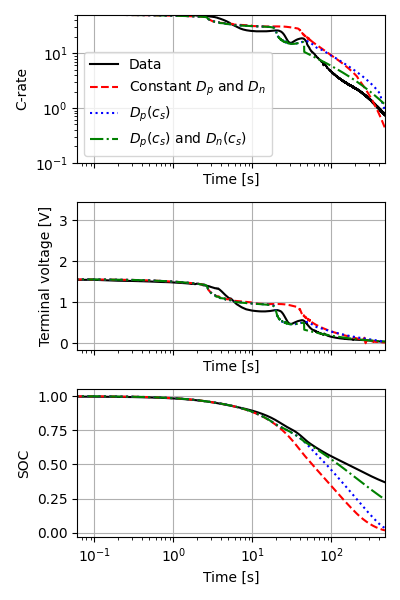

In [9]:
%matplotlib widget
labels = ["Constant $D_p$ and $D_n$", "$D_p(c_s)$", "$D_p(c_s)$ and $D_n(c_s)$"]

fig, ax = plt.subplots(3,1, figsize=(4,6), sharex=True)
ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['r','b','g']

for l, solution in enumerate(solutions):
    # data = data_sets[l]
    t = solution["Time [s]"].entries
    x = solution["x [m]"].entries[:, 0]
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t
    xlabel = "Time [s]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = 'k' 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    I = solution['C-rate']
    if l ==0:
        ax[0].loglog(data.t,data.I/param['Nominal cell capacity [A.h]'], label='Data',color = data_color)
    ax[0].loglog(x_plot, I(t), linestyle=sim_ls, color = sim_color, label=labels[l])
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('C-rate')
    ax[0].set_ylim([0.1,50])
    ax[0].legend(loc = "lower left",  prop={'size': 10})

    V = solution['Terminal voltage [V]']
    if l ==0:
        ax[1].semilogx(data.t, data.V,color = data_color)
    ax[1].semilogx(x_plot, V(t),linestyle=sim_ls, color = sim_color)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Terminal voltage [V]')
    # ax[0,1].set_ylim([3,4.2])
    # ax[0,1].legend(bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=len(SOC_0), prop={'size': 10}) #, 


    # T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    # if l ==0:
    #     ax[2].semilogx(data.t, data.Temp,color = data_color)
    # ax[2].semilogx(x_plot, T,linestyle=sim_ls, color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[2].set_xlabel(xlabel)
    # ax[2].set_ylabel('Temperature [$^\circ$C]')

    c_n_avg = solution['R-averaged negative particle concentration'](t=t, x=x[0])
    # c_p_avg = solution['R-averaged positive particle concentration']
    # soc = (c_n_avg - 0.036)/(0.842-0.036)
    soc = (c_n_avg - 0)/(0.8321-0)
    e_soc = (solution['R-averaged negative particle concentration'](t=data.t, x=x[0])- 0)/(0.8321-0) -  data.SOC
    x = solution["x [m]"].entries[:, 0]
    if l ==0:
        ax[2].plot(data.t, data.SOC,color = data_color, label = 'Data')
    ax[2].plot(x_plot, soc,linestyle=sim_ls, color = sim_color, label = labels[l])  # can evaluate at arbitrary x (single representative particle)
    # ax[1,0].plot(data.t, e_soc,linestyle=':', color = sim_color, label = labels[l] + ": SOC" )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,0].semilogx(x_plot, c_p_avg(t=t, x=x[-1]),linestyle=':', color = sim_color, label = labels[l] + ": $c_{p,avg} $")  # can evaluate at arbitrary x (single representative particle)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel('SOC')
    # ax[1,0].legend(loc = 'center right')
    # ax[3].legend(loc = "lower left",  prop={'size': 10})

    # # calculate and print errors
    # t_error = data.t[data.I>1].to_numpy()
    # rmse_I = np.sqrt(np.mean(np.square(data.I[data.I>1]- I(t_error))))
    # # print('RMSE C-rate: ' + str(round(rmse_I/param['Nominal cell capacity [A.h]'],4)))
    # rmse_V = np.sqrt(np.mean(np.square(data.V[data.I>1]- V(t_error))))
    # # print('RMSE V: ' + str(round(rmse_V,5)))
    # e_V = abs(data.V - V(data.t))
    # ax[1,1].semilogx(data.t, e_V,color = sim_color,label = labels[l] + ': RMSE = ' + str(np.round(rmse_V,4)))  # can evaluate at arbitrary x (single representative particle)
    # ax[1,1].set_xlabel(xlabel)
    # ax[1,1].set_ylabel('|$e_V$| [V]')
    # ax[1,1].legend(loc = 'upper center')
    # ax[1,1].set_ylim([0,0.5])

    # Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])/1e-14
    # Dp = solution['X-averaged positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-1],r=[0])/1e-15
    # ax[1,2].semilogx(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$ [1e-14]")  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].semilogx(x_plot, Dp, linestyle=':', color = sim_color, label = "$D_p$ [1e-15]")  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].set_xlabel(xlabel)
    # ax[1,2].set_ylabel('$D_p$ [1e-15] and $D_n$ [1e-14]')
    # ax[1,2].legend(loc = 'upper left', ncol=2)

    # plot venting line 
    # c = 'grey'
    for i, axs in enumerate(fig.get_axes()):
    #     ylims = axs.get_ylim()
    #     axs.plot([80]*2, list(ylims), color = c, linestyle = ':')
    #     if i ==0:
    #         axs.annotate('Venting', xy=(90, np.diff(ylims)*0.57+ ylims[0]), color = c, rotation=-90) #
    #     axs.set_ylim(ylims) # keep original limits
        axs.grid()



# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True) #ncol=len(labels)
plt.xlim([t_eval[0],t_eval[-1]])
plt.tight_layout()
plt.show()



## FIG: Slower diffusion after venting

No such comm: 412c10340e164b4b870f33bddf8dd75c


2023-05-09 16:07:27.168 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:07:27.173 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:07:27.173 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:07:27.173 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')


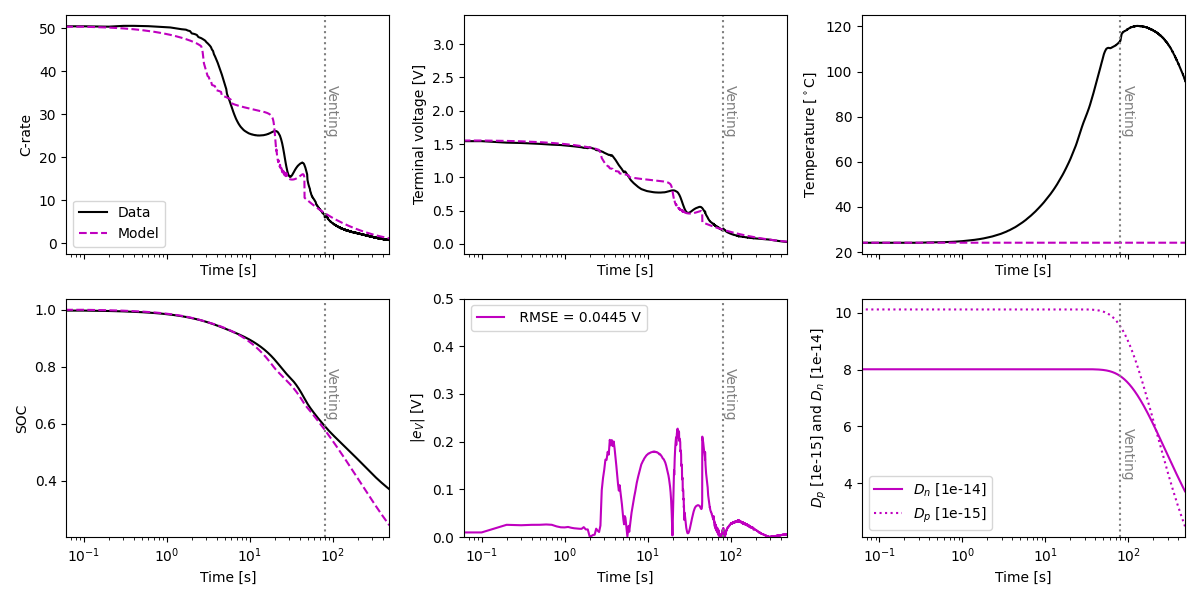

In [10]:
%matplotlib widget

fig, ax = plt.subplots(2, 3, figsize=(12,6), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','-.']*2
solution = solutions[-1]    # data = data_sets[l]
t = solution["Time [s]"].entries
x = solution["x [m]"].entries[:, 0]
# AhT = solution["Discharge capacity [A.h]"].entries
x_plot = t
xlabel = "Time [s]"
# x_plot = solution["Discharge capacity [A.h]"].entries
# xlabel = "AhT"
data_color = 'k' 
sim_color = 'm'
sim_ls = '--'
I = solution['C-rate']
ax[0,0].semilogx(data.t,data.I/param['Nominal cell capacity [A.h]'], label='Data',color = data_color)
ax[0,0].semilogx(x_plot, I(t), linestyle= sim_ls, color = sim_color, label='Model')
ax[0,0].set_xlabel(xlabel)
ax[0,0].set_ylabel('C-rate')
ax[0,0].legend()

V = solution['Terminal voltage [V]']
ax[0,1].semilogx(data.t, data.V,color = data_color)
ax[0,1].semilogx(x_plot, V(t),linestyle=sim_ls, color = sim_color)
ax[0,1].set_xlabel(xlabel)
ax[0,1].set_ylabel('Terminal voltage [V]')


T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
ax[0,2].semilogx(data.t, data.Temp,color = data_color)
ax[0,2].semilogx(x_plot, T,linestyle=sim_ls, color = sim_color )  
ax[0,2].set_xlabel(xlabel)
ax[0,2].set_ylabel('Temperature [$^\circ$C]')

c_n_avg = solution['R-averaged negative particle concentration'](t=t, x=x[0])
soc = (c_n_avg - 0)/(0.8321-0)
e_soc = (solution['R-averaged negative particle concentration'](t=data.t, x=x[0])- 0)/(0.8321-0) -  data.SOC
x = solution["x [m]"].entries[:, 0]
ax[1,0].plot(data.t, data.SOC,color = data_color)
ax[1,0].plot(x_plot, soc,linestyle='--', color = sim_color)  # can evaluate at arbitrary x (single representative particle)
ax[1,0].set_xlabel(xlabel)
ax[1,0].set_ylabel('SOC')

# calculate and print errors
t_error = data.t[data.I>1].to_numpy()
rmse_I = np.sqrt(np.mean(np.square(data.I[data.I>1]- I(t_error))))
# print('RMSE C-rate: ' + str(round(rmse_I/param['Nominal cell capacity [A.h]'],4)))
rmse_V = np.sqrt(np.mean(np.square(data.V[data.I>1]- V(t_error))))
# print('RMSE V: ' + str(round(rmse_V,5)))
e_V = abs(data.V - V(data.t))
ax[1,1].semilogx(data.t, e_V,color = sim_color,label =' RMSE = ' + str(np.round(rmse_V,4)) + ' V')  # can evaluate at arbitrary x (single representative particle)
ax[1,1].set_xlabel(xlabel)
ax[1,1].set_ylabel('|$e_V$| [V]')
ax[1,1].legend()
ax[1,1].set_ylim([0,0.5])

Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])/1e-14
Dp = solution['X-averaged positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-1],r=[0])/1e-15
ax[1,2].semilogx(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$ [1e-14]")  # can evaluate at arbitrary x (single representative particle)
ax[1,2].semilogx(x_plot, Dp, linestyle=':', color = sim_color, label = "$D_p$ [1e-15]")  # can evaluate at arbitrary x (single representative particle)
ax[1,2].set_xlabel(xlabel)
ax[1,2].set_ylabel('$D_p$ [1e-15] and $D_n$ [1e-14]')
ax[1,2].legend(loc = 'lower left')

# plot venting lines
for i,axs in enumerate(fig.get_axes()):
    ylims = axs.get_ylim()
    axs.plot([80]*2, list(ylims), color = 'grey', linestyle = ':')
    if i == (len(fig.get_axes())-1): 
        axs.annotate('Venting', xy=(80, np.diff(ylims)*0.25+ ylims[0]), rotation=-90, color = 'grey')
    else:
        axs.annotate('Venting', xy=(80, np.diff(ylims)*0.5+ ylims[0]), rotation=-90, color = 'grey')
    axs.set_ylim(ylims) # keep original limits



# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
handles, labels = ax[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True)
plt.xlim([t_eval[0],t_eval[-1]])
plt.tight_layout()
plt.show()

# Simulate 100%, 75%, and 50% initial SOC

In [13]:
solutions = []
SOC_0 = [1,0.75, 0.5, 0.15]
SOC_name = SOC_0
Q_nom = 4.5
h = 0.72753047-0.05 #0.77996386
Cp = 1.51997699 #1.94584251
R_tab = pybamm.Parameter("Tabbing resistance [Ohm]")
R_ext = pybamm.Parameter("External resistance [Ohm]")
data_sets = []
R_tab_list =  [0.0085,0.0085, 0.007] # 0.0085 (100%), 0.0078 (75%), 0.007? (50%)
R_ext_list =  [0.0067,0.0145-R_tab_list[1], 0.0067] # 0.0085 (100%), 0.0078 (75%), 0.007? (50%)

for j, soc in enumerate(SOC_0):

    # load data import ESC data from file
    raw_data = pd.read_csv("./fast_discharge/ESC_"+  str(int(SOC_name[j]*100)) + "SOC_full.csv")
    esc_start = raw_data[-raw_data['Current Shunt']>1].index[0]
    esc_end = len(raw_data)
    # T_amb = np.mean(raw_data['Cell Temperature'][(raw_data.index < esc_start) & (raw_data['Cell Temperature'] >0)])
    data = raw_data[['Time (s)', 'Voltage (V)', 'Cell Temperature', 'Current Shunt', 'Force']].loc[esc_start:esc_end].copy()
    data['Current Shunt'] = -data['Current Shunt']
    data['Time (s)'] = data['Time (s)'] - data['Time (s)'].loc[esc_start]
    df_labels = ['t', 'V', 'Temp','I', 'F']
    data.set_axis(df_labels, axis=1, inplace=True)
    data['I_C'] = data.I/Q_nom 
    AhT_calculated = integrate.cumtrapz(abs(data.I), data.t-data.t.iloc[0])/3600
    AhT_calculated = np.append(AhT_calculated,AhT_calculated[-1])
    data['SOC'] = soc - AhT_calculated/Q_nom 
    T_amb = data.Temp.iloc[0]
    data_sets.append(data)

    options = {
        # "thermal": "x-lumped",
#         "side reactions": "decomposition", 
        "operating mode": ExternalCircuitResistanceFunction(),
    }
    model = pybamm.lithium_ion.SPMe(options = options)
    chemistry = pybamm.parameter_sets.Mohtat2020
    # chemistry["electrolyte"] = "lipf6_Nyman2008"
    # chemistry["electrolyte"] = "LiPF6_Mohtat2020"
    param = pybamm.ParameterValues(chemistry)
    
    param.update({
        "Tabbing resistance [Ohm]":  R_tab_list[j],#0.0041,D
        "External resistance [Ohm]":  R_ext_list[j], # 0.0067
        "Cell capacity [A.h]": 4.6, #nominal
        "Typical current [A]": 4.6,
        "Negative electrode thickness [m]":62E-06*4.2/5,
        "Positive electrode thickness [m]":67E-06*4.2/5,
        "Lower voltage cut-off [V]": 0,
        "Ambient temperature [K]":T_amb + 273.15,
        "Initial temperature [K]": T_amb + 273.15,
        "Negative tab width [m]":2.5e-2,
        "Positive tab width [m]":2.5e-2,
        "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Negative tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Positive tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Edge heat transfer coefficient [W.m-2.K-1]":h,
        "Total heat transfer coefficient [W.m-2.K-1]":h,
        "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Negative electrode diffusivity [m2.s-1]": modified_graphite_diffusivity_PeymanMPM,
        "Positive electrode diffusivity [m2.s-1]": modified_NMC_diffusivity_PeymanMPM,
        "Electrolyte diffusivity [m2.s-1]": modified_electrolyte_diffusivity_PeymanMPM,
        "Electrolyte conductivity [S.m-1]": modified_electrolyte_conductivity_PeymanMPM,
        # "Diffusion stoichiometry scalar": 2,
        # "Diffusion stoichiometry offset": 1,
        # "Electrolyte diffusion scalar":100,
    }, check_already_exists = False)

    V = model.variables["Terminal voltage [V]"]
    I = model.variables["Current [A]"]
    model.variables.update({
        "Terminal voltage [V]": V - I*R_tab,
        "Actual resistance [Ohm]":V/I,
        }
    )
    
    dt = 0.1
    t_eval = np.arange(0, 15*60, dt)
    solver = pybamm.CasadiSolver(mode="safe", dt_max = 1) #, extra_options_setup={"max_num_steps": 10000}
    sim = pybamm.Simulation(model, parameter_values = param, solver=solver) 
    solution = sim.solve( initial_soc=soc, t_eval = t_eval)
    solutions.append(solution)

IndexError: list index out of range

## FIG: 100%, 75%, and 50% SOC

2023-05-09 16:09:00.351 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:09:00.367 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:09:00.369 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:09:00.377 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:09:00.379 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:09:00.390 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:09:02.227 - [WARNING] processed_variable.__call__(459): Calling variable outside interpolation range (returns 'nan')
2023-05-09 16:09:02.236 - [WARNING] processed_variable.__call__(459): Calling varia

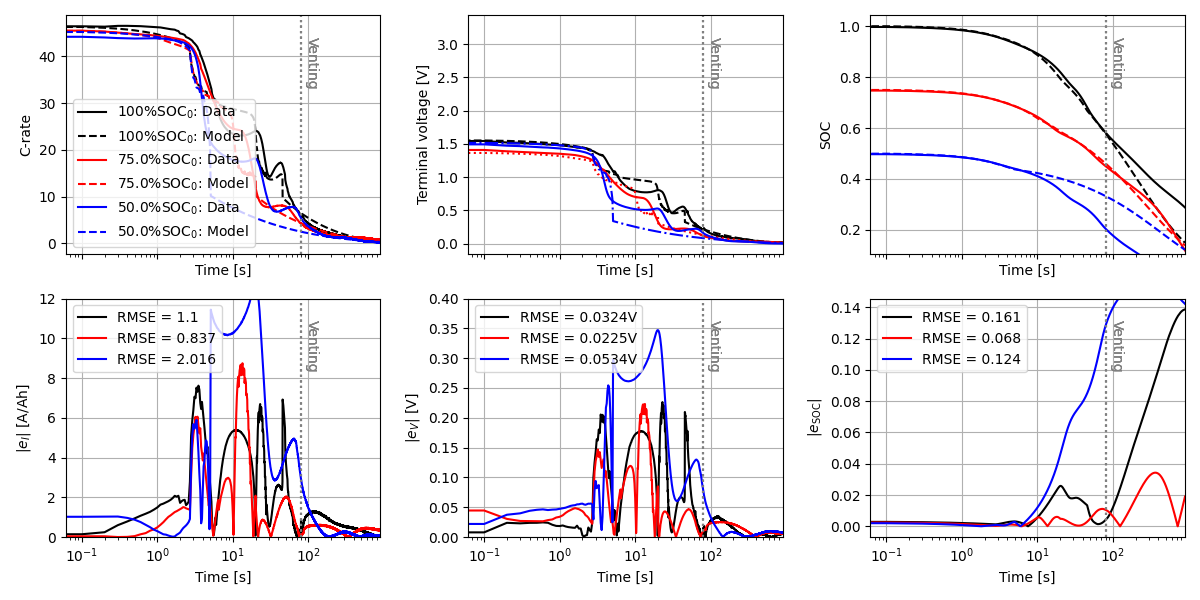

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
%matplotlib widget

labels = [str(soc*100) + '%SOC$_0$' for soc in SOC_name]
%matplotlib widget

fig, ax = plt.subplots(2, 3, figsize=(12,6), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['k','r','b','m']
for l, (solution,data) in enumerate(zip(solutions, data_sets)):
    # data = data_sets[l]
    t = solution["Time [s]"].entries
    x = solution["x [m]"].entries[:, 0]
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t
    xlabel = "Time [s]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = sim_colors[l] 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    I = solution['C-rate']
    ax[0,0].semilogx(data.t,data.I/param['Nominal cell capacity [A.h]'], label=labels[l] + ': Data',color = data_color)
    ax[0,0].semilogx(x_plot, I(t), linestyle='--', color = sim_color, label=labels[l] + ': Model')
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel('C-rate')
    ax[0,0].legend()

    V = solution['Terminal voltage [V]']
    ax[0,1].semilogx(data.t, data.V,color = data_color)
    ax[0,1].semilogx(x_plot, V(t),linestyle=sim_ls, color = sim_color)
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel('Terminal voltage [V]')
    # ax[0,1].set_ylim([3,4.2])
    # ax[0,1].legend(bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=len(SOC_0), prop={'size': 10}) #, 


    # T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    # ax[0,2].semilogx(data.t, data.Temp,color = data_color)
    # ax[0,2].semilogx(x_plot, T,linestyle=sim_ls, color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    # ax[0,2].set_xlabel(xlabel)
    # ax[0,2].set_ylabel('Temperature [$^\circ$C]')

    c_n_avg = solution['R-averaged negative particle concentration'](t=t, x=x[0])
    # c_p_avg = solution['R-averaged positive particle concentration']
    # soc = (c_n_avg - 0.036)/(0.842-0.036)
    soc = (c_n_avg - 0)/(0.8321-0)
    e_soc = (solution['R-averaged negative particle concentration'](t=data.t, x=x[0])- 0)/(0.8321-0) -  data.SOC
    x = solution["x [m]"].entries[:, 0]
    ax[0,2].semilogx(data.t, data.SOC,color = data_color)
    ax[0,2].semilogx(x_plot, soc,linestyle='--', color = sim_color, label = labels[l] + ": SOC" )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,0].plot(data.t, e_soc,linestyle=':', color = sim_color, label = labels[l] + ": SOC" )  # can evaluate at arbitrary x (single representative particle)
    # ax[1,0].semilogx(x_plot, c_p_avg(t=t, x=x[-1]),linestyle=':', color = sim_color, label = labels[l] + ": $c_{p,avg} $")  # can evaluate at arbitrary x (single representative particle)
    ax[0,2].set_xlabel(xlabel)
    ax[0,2].set_ylabel('SOC')
    # ax[1,0].legend(loc = 'center right')


    # calculate and print errors
    t_error = data.t[data.I>1].to_numpy()
    rmse_I = np.sqrt(np.mean(np.square(data.I[data.I>1]/param['Nominal cell capacity [A.h]']- I(t_error))))
    e_I = abs(data.I/param['Nominal cell capacity [A.h]'] - I(data.t))
    ax[1,0].semilogx(data.t, e_I,color = sim_color,label = 'RMSE = ' + str(np.round(rmse_I,3)))  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel('|$e_I$| [A/Ah]')
    ax[1,0].legend(loc = 'upper left')
    ax[1,0].set_ylim([0,12])

  
    # print('RMSE C-rate: ' + str(round(rmse_I/param['Nominal cell capacity [A.h]'],4)))
    rmse_V = np.sqrt(np.mean(np.square(data.V[data.I>1]- V(t_error))))
    # print('RMSE V: ' + str(round(rmse_V,5)))
    e_V = abs(data.V - V(data.t))
    ax[1,1].semilogx(data.t, e_V,color = sim_color,label = 'RMSE = ' + str(np.round(rmse_V,4)) + 'V')  # can evaluate at arbitrary x (single representative particle)
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel('|$e_V$| [V]')
    ax[1,1].legend(loc = 'upper left')
    ax[1,1].set_ylim([0,0.4])


    # Dn = solution['X-averaged negative particle effective diffusivity [m2.s-1]'](t=t, x=x[0],r=[0])/1e-14
    # Dp = solution['X-averaged positive particle effective diffusivity [m2.s-1]'](t=t, x=x[-1],r=[0])/1e-15
    # ax[1,2].semilogx(x_plot, Dn, linestyle='-', color = sim_color, label = "$D_n$ [1e-14]")  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].semilogx(x_plot, Dp, linestyle=':', color = sim_color, label = "$D_p$ [1e-15]")  # can evaluate at arbitrary x (single representative particle)
    # ax[1,2].set_xlabel(xlabel)
    # ax[1,2].set_ylabel('$D_p$ [1e-15] and $D_n$ [1e-14]')
    # ax[1,2].legend(loc = 'lower left', ncol=2)

    # print('RMSE C-rate: ' + str(round(rmse_I/param['Nominal cell capacity [A.h]'],4)))
    rmse_soc = np.sqrt(np.mean(np.square(data.SOC[data.I>1]- solution['R-averaged negative particle concentration'](t=t_error, x=x[0])- 0)/(0.8321-0)))
    ax[1,2].semilogx(data.t, abs(e_soc),color = sim_color,label = 'RMSE = ' + str(np.round(rmse_soc,3)))  # can evaluate at arbitrary x (single representative particle)
    ax[1,2].set_xlabel(xlabel)
    ax[1,2].set_ylabel('|$e_{\mathrm{SOC}}$|')
    ax[1,2].legend(loc = 'upper left')
    # ax[1,1].set_ylim([0,0.4])


    # plot venting line 
    c = 'grey'
    for i, axs in enumerate(fig.get_axes()):
        ylims = axs.get_ylim()
        # if i <(len(fig.get_axes())-1):
        axs.plot([80]*2, list(ylims), color = c, linestyle = ':')
        axs.annotate('Venting', xy=(90, np.diff(ylims)*0.7+ ylims[0]), color = c, rotation=-90) #
        axs.set_ylim(ylims) # keep original limits
        axs.grid()


# ax[0,1].legend(handles,loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=3, prop={'size': 10})
handles, labels = ax[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=len(SOC_0), prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True)
plt.xlim([t_eval[0],t_eval[-1]])
plt.tight_layout()
plt.show()
plt.savefig('./fast_discharge/figs/100_75.eps', format='eps')


# Plot vs time large

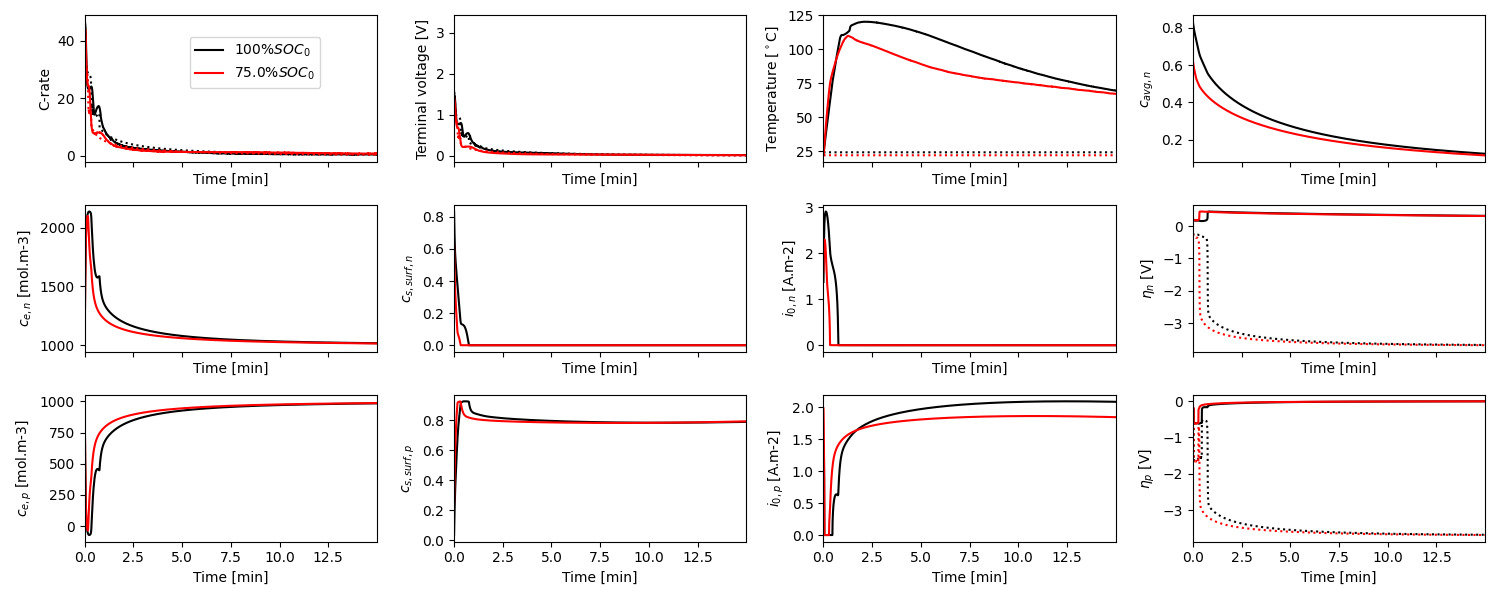

In [101]:
%matplotlib widget

labels = [str(soc*100) + '$\%SOC_0$' for soc in SOC_0]
fig, ax = plt.subplots(3, 4, figsize=(15,6), sharex=True)
# ax = ax.flatten()
linestyles = ['-','--',':','.-']*2
sim_colors = ['k', 'r', 'b','g']
for l, solution in enumerate(solutions):
    data = data_sets[l]
    t = solution["Time [s]"].entries
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t/60
    xlabel = "Time [min]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"
    data_color = sim_colors[l]
    sim_color = sim_colors[l]
    I = solution['C-rate']
    ax[0,0].plot(data.t/60,data.I/param['Nominal cell capacity [A.h]'], label=labels[l],color = data_color)
    ax[0,0].plot(x_plot, I(t), linestyle=':',color = sim_color )
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel('C-rate')


    V = solution['Terminal voltage [V]']
    ax[0,1].plot(data.t/60,data.V,color = data_color)
    ax[0,1].plot(x_plot, V(t), linestyle=':',color = sim_color )
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel('Terminal voltage [V]')

    T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    ax[0,2].plot(data.t/60,data.Temp,color = data_color)
    ax[0,2].plot(x_plot, T,linestyle=':',color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[0,2].set_xlabel(xlabel)
    ax[0,2].set_ylabel('Temperature [$^\circ$C]')

    soc = solution['R-averaged negative particle concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[0,3].plot(x_plot, soc(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[0,3].set_xlabel(xlabel)
    ax[0,3].set_ylabel('$c_{avg,n}$')

    c_e_n = solution['X-averaged negative electrolyte concentration [mol.m-3]']
    # x = solution["x [m]"].entries[:, 0]
    ax[1,0].plot(x_plot, c_e_n (t=t),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel('$c_{e,n}$ [mol.m-3]')

    c_s_n_surf = solution['Negative particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[1,1].plot(x_plot, c_s_n_surf(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel('$c_{s,surf,n}$')


    i0 = solution[ 'Negative electrode exchange current density [A.m-2]']
    x = solution["x [m]"].entries[:, 0]
    ax[1,2].plot(x_plot, i0(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[1,2].set_xlabel(xlabel)
    ax[1,2].set_ylabel('$i_{0,n}$ [A.m-2]')

    eta = solution['Negative electrode reaction overpotential [V]']
    phi = solution['Negative electrolyte potential [V]']
    x = solution["x [m]"].entries[:, 0]
    ax[1,3].plot(x_plot, eta(t=t, x=x[0]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[1,3].plot(x_plot, phi(t=t, x=x[0]),color = sim_color, linestyle = ':' )  # can evaluate at arbitrary x (single representative particle)
    ax[1,3].set_xlabel(xlabel)
    ax[1,3].set_ylabel('$\eta_n$ [V]')

    c_e_p= solution['X-averaged positive electrolyte concentration [mol.m-3]']
    # x = solution["x [m]"].entries[:, 0]
    ax[2,0].plot(x_plot, c_e_p (t=t),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[2,0].set_xlabel(xlabel)
    ax[2,0].set_ylabel('$c_{e,p}$ [mol.m-3]')

    c_s_p_surf = solution['Positive particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[2,1].plot(x_plot, c_s_p_surf(t=t, x=x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[2,1].set_xlabel(xlabel)
    ax[2,1].set_ylabel('$c_{s,surf,p}$')

    i0 = solution[ 'Positive electrode exchange current density [A.m-2]']
    x = solution["x [m]"].entries[:, 0]
    ax[2,2].plot(x_plot, i0(t=t, x=x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[2,2].set_xlabel(xlabel)
    ax[2,2].set_ylabel('$i_{0,p}$ [A.m-2]')

    eta = solution['Positive electrode reaction overpotential [V]']
    phi = solution['Positive electrolyte potential [V]']
    x = solution["x [m]"].entries[:, 0]
    ax[2,3].plot(x_plot, eta(t=t, x=x[-1]),color = sim_color )  # can evaluate at arbitrary x (single representative particle)
    ax[2,3].plot(x_plot, phi(t=t, x=x[-1]),color = sim_color, linestyle = ':' )  # can evaluate at arbitrary x (single representative particle)
    ax[2,3].set_xlabel(xlabel)
    ax[2,3].set_ylabel('$\eta_p$ [V]')

plt.xlim([t_eval[0],t_eval[-1]/60])
ax = ax.flatten()
lines_labels = [ax.get_legend_handles_labels() for ax in ax]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.17, 0.95), fancybox=True)
# fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), fancybox=True, ncol = len(labels))

plt.tight_layout()
plt.show()


In [176]:
t_error = data.t[data.t<max(t_eval)].to_numpy()

rmse_I = np.sqrt(np.mean(np.square(data.I[data.t<max(t_eval)] - I(t_error))))
print('RMSE C-rate: ' + str(rmse_I/param['Nominal cell capacity [A.h]']))

rmse_V = np.sqrt(np.mean(np.square(data.V[data.t<max(t_eval)] - V(t_error))))
print('RMSE V: ' + str(rmse_V))

# rmse_T = np.sqrt(np.mean(np.square(data['Cell Temperature'] - T)))
# print(rmse_T)


RMSE C-rate: 6.740096760959483
RMSE V: 0.08105375330020799


In [85]:
print(I(0))
print(data.I.iloc[1]/param['Nominal cell capacity [A.h]'])
print(V(0))
print(data.V.iloc[1])

46.249546284072075
46.44093824
1.5493598005191054
1.56482623


# Quickplot

In [478]:
%matplotlib inline

solution = solutions[0]
quick_plot = pybamm.QuickPlot(solution, figsize=[10,7],n_rows = 4, output_variables=[ 
    'Current [A]', 
    'X-averaged negative electrode exchange current density [A.m-2]',
    'X-averaged positive electrode exchange current density [A.m-2]',

    'Terminal voltage [V]',
    'X-averaged negative particle surface concentration',
    'X-averaged positive particle surface concentration',

    'Volume-averaged cell temperature [K]',
    'X-averaged negative particle concentration', 
    'X-averaged positive particle concentration',

    'Discharge capacity [A.h]',
    'Negative electrolyte concentration',
    'Positive electrolyte concentration',
    ])
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=479.90000000000003, step=4.799), Output()), …

# SOC error vs T

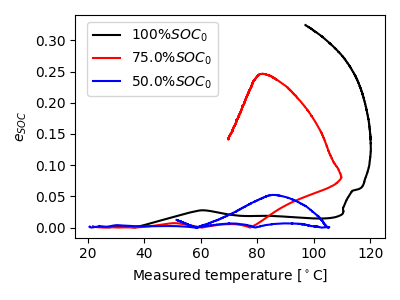

In [358]:
%matplotlib widget

labels = [str(soc*100) + '$\%SOC_0$' for soc in SOC_0]
%matplotlib widget

fig, ax = plt.subplots(1,1, figsize=(4,3), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['k','r','b','m']
for l, (solution,data) in enumerate(zip(solutions, data_sets)):
    # data = data_sets[l]

    data_color = sim_colors[l] 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    
    c_n_avg = solution['R-averaged negative particle concentration'](t=data.t, x=x[0])
    soc = (c_n_avg - 0)/(0.8321-0)
    e_soc = abs(data.SOC - soc)
    ax.plot(data.Temp,e_soc, color = sim_colors[l], label = labels[l])
    ax.set_ylabel('$e_{SOC}$')
    ax.set_xlabel('Measured temperature [$^\circ$C]')



handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left',  bbox_to_anchor=(0.2, .95), fancybox=True)# , loc='upper center', ncol=len(SOC_0), prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True
plt.tight_layout()
plt.show()
# plt.grid()

In [246]:
data.clip(lower=0)

,t,V,Temp,I,F,I_C,SOC,dF
4192,0.000,4.176052,24.111259,0.824988,13.824123,0.183331,0.999281,0.061497
4193,0.100,1.564826,24.140908,232.204691,13.885620,51.601042,0.997847,0.009710
4194,0.200,1.543099,24.121142,232.228600,13.895330,51.606356,0.996415,0.048550
4195,0.300,1.521092,24.150790,231.838083,13.943881,51.519574,0.994981,0.000000
4196,0.400,1.515830,24.121142,232.698815,13.943881,51.710848,0.993545,0.000000
...,...,...,...,...,...,...,...,...
8908,471.602,0.031515,97.072092,3.562563,0.605449,0.791681,0.356665,0.000000
8909,471.702,0.031395,97.062462,3.598427,0.602212,0.799650,0.356643,0.000000
8910,471.802,0.031355,97.062462,3.558579,0.563372,0.790795,0.356621,0.000000
8911,471.902,0.031435,97.033575,3.550609,0.547188,0.789024,0.356599,0.000000


In [312]:
data = {'a': [9, -3, 10, -1, 11], 'b': [-2, -7, 6, 8, -5]}
df = pd.DataFrame(data)
df['c'] = np.diff(np.append(df.a, df.a.iloc[-1]))
d = df.clip(lower=0).c
df['d'] = np.cumsum(d)


print(df)

    a  b   c   d
0   9 -2 -12   0
1  -3 -7  13  13
2  10  6 -11  13
3  -1  8  12  25
4  11 -5   0  25


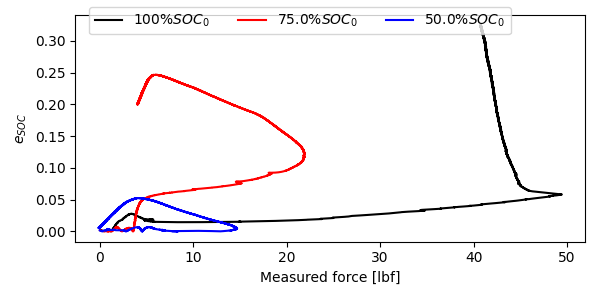

In [331]:
%matplotlib widget

labels = [str(soc*100) + '$\%SOC_0$' for soc in SOC_0]
%matplotlib widget

fig, ax = plt.subplots(1,1, figsize=(6,3), sharex=True)
# ax = ax.flatten()
linestyles = ['--',':','-.']*2
sim_colors = ['k','r','b','m']
for l, (solution,data0) in enumerate(zip(solutions, data_sets)):
    data = data0.copy()
    data['dF'] = np.diff(np.append(data.F, data.F.iloc[-1]))
    pos_F = np.cumsum(data.clip(lower=-0.1).dF)
    data.F = pos_F

    data_color = sim_colors[l] 
    sim_color = sim_colors[l]
    sim_ls = linestyles[l]
    t_end = 10*60
    c_n_avg = solution['R-averaged negative particle concentration'](t=data.t[data.t<t_end], x=x[0])
    soc = (c_n_avg - 0)/(0.8321-0)
    e_soc = abs(data.SOC[data.t<t_end] - soc)
    # ax.plot(data.t/60,data.F, color = sim_colors[l], label = labels[l])
    ax.plot(data.F[data.t<t_end], e_soc, color = sim_colors[l], label = labels[l])
    ax.set_ylabel('$e_{SOC}$')
    ax.set_xlabel('Measured force [lbf]')



handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(SOC_0), prop={'size': 10},  bbox_to_anchor=(0.5, 1), fancybox=True)
plt.tight_layout()
plt.show()


In [315]:
solutions = []
SOC_0 = [1]
h = 6
Cp = 2
R_tab = pybamm.Parameter("Tabbing resistance [Ohm]")
R_ext = pybamm.Parameter("External resistance [Ohm]")
data_sets = []

for j, soc in enumerate(SOC_0):
    # load data import ESC data from file
    data = pd.read_csv("./fast_discharge/ESC_"+  str(int(soc*100)) + "SOC_full.csv")
    data.I = -data.I
    esc_start = data[data.I>1].index[0]-1
    data = data.loc[esc_start::]
    data.t = data.t - data.t.loc[esc_start]
    # print([key for key in data.keys()])
    # data.head()
    data_sets.append(data)

    options = {
        # "thermal": "x-lumped",
        # "intercalation kinetics": "high-current Butler-Volmer",
#         "side reactions": "decomposition", 
        # "operating mode": ExternalCircuitResistanceFunction(),
    }
    model = pybamm.lithium_ion.SPMe(options = options)
    param = pybamm.ParameterValues(pybamm.parameter_sets.Mohtat2020)
    param.update({
        "Tabbing resistance [Ohm]":  0.0095,#0.0041,D
        "External resistance [Ohm]": 0.0067, # 0.0067
        "Cell capacity [A.h]": 4.6, #nominal
        "Typical current [A]": 4.6,
        "Lower voltage cut-off [V]": 0,
        "Ambient temperature [K]":296.7,
        "Initial temperature [K]": 296.7,
        "Negative tab width [m]":2.5e-2,
        "Positive tab width [m]":2.5e-2,
        "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Negative tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Positive tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Edge heat transfer coefficient [W.m-2.K-1]":h,
        "Total heat transfer coefficient [W.m-2.K-1]":h,
        # "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        # "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Negative electrode diffusivity [m2.s-1]": modified_graphite_diffusivity_PeymanMPM,
        "Positive electrode diffusivity [m2.s-1]": modified_NMC_diffusivity_PeymanMPM,
        # "Electrolyte diffusivity [m2.s-1]": modified_electrolyte_diffusivity_PeymanMPM,
        # "Diffusion stoichiometry scalar": 2,
        # "Diffusion stoichiometry offset": 1,
        "Electrolyte diffusion scalar":1/3,

    }, check_already_exists = False)

    V = model.variables["Terminal voltage [V]"]
    I = model.variables["Current [A]"]
    model.variables.update({
        "Terminal voltage [V]": V - I*R_tab,
        "Actual resistance [Ohm]":V/I,
        }
    )


    # initialize 
    c_n = model.variables["X-averaged negative particle concentration"]
    c_p = model.variables["X-averaged positive particle concentration"]
    I = model.variables["Total current density"]
    Q = model.variables["Discharge capacity [A.h]"]
    # T = model.variables["Volume-averaged cell temperature"]

    experiment = pybamm.Experiment([
        # " for 1 minute",
        "Discharge at 0.0001 A for 1 minute",
        "Rest for 1 minute"
    ])
    sim_rest = pybamm.Simulation(model,  parameter_values = param, experiment=experiment)
    solution_sim_rest = sim_rest.solve()
    # rested_model = model.set_initial_conditions_from(solution_sim_rest, inplace=False)
    # dt = 0.1
    # t_eval = np.arange(0, 10*60, dt)
    # solver = pybamm.CasadiSolver(mode="safe", dt_max= 1e-6, extra_options_setup={"max_num_steps": 10000})
    # sim = pybamm.Simulation(rested_model, parameter_values = param, solver=solver)
    # solution = sim.solve( initial_soc=soc, t_eval = t_eval)
    # solutions.append(solution)

AttributeError: 'DataFrame' object has no attribute 'I'

In [9]:
display([k for k in model.variables.keys()])

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'r_p',
 'r_p [m]',
 'r_n',
 'r_n [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Throughput capacity [A.h]',
 'Porosity',
 'Separator porosity',
 'Positive electrode porosity',
 'X-averaged separator porosity',
 'X-averaged positive electrode porosity',
 'Negative electrode porosity',
 'X-averaged negative electrode porosity',
 'Leading-order porosity',
 'Leading-order separator porosity',
 'Leading-order positive electrode porosity',
 'Leading-order x-averaged separator porosity',
 'Leading-order x-averaged positive electrode porosity',
 'Leading-order negative electrode porosity',
 'Leading-order x-averaged negative electrode porosity',
 'Porosity change',
 'Separator porosity change',
 'Positive elect

In [10]:
print(inspect.getsource(param['Negative electrode exchange-current density [A.m-2]']))


def graphite_electrolyte_exchange_current_density_PeymanMPM(c_e, c_s_surf, c_s_max, T):
    """
    Exchange-current density for Butler-Volmer reactions between graphite and LiPF6 in
    EC:DMC.
    Check the unit of Reaction rate constant k0 is from Peyman MPM.

    References
    ----------
    .. [2] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref =  Parameter("Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4*1.061 * 10 ** (-6)  # unit has been converted
    # units are (A/m2)(mol/m3)**1.5 - includes ref conc

# References

The relevant papers for this notebook are:

In [11]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of the Electrochemical Society, 159(10):A1730, 2012. doi:10.1149/2.049210jes.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(782

In [ ]:
param.search('Diffusivity')

EC diffusivity [m2.s-1]	2e-18
Electrolyte diffusivity [m2.s-1]	<function electrolyte_diffusivity_PeymanMPM at 0x000001C23D99EC10>
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Negative electrode diffusivity [m2.s-1]	<function graphite_diffusivity_PeymanMPM at 0x000001C23D99E940>
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Positive electrode diffusivity [m2.s-1]	<function NMC_diffusivity_PeymanMPM at 0x000001C23D99E700>
Typical electrolyte diffusivity [m2.s-1]	5.35e-10
